## Periodic Retraining 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import time
import datetime

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sreejithsreekumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Create sample notes

In [4]:
notes_directory = "sample_notes/"

In [5]:
with open("shakespeare.txt") as f:
    txt = f.read()

sonnets = txt.split("\n\n")

for i, sonnet in enumerate(sonnets):
    with open(notes_directory + "/" + str(i) + ".txt", "w") as f:
        f.write(sonnet)

#### Read each note as a row in a dataframe

In [6]:
df = pd.DataFrame(sonnets)[2:]
df.columns = ["note"]

display(df.head(2))

,note
2,"From fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light's flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:\nThou that art now the world's fresh ornament,\nAnd only herald to the gaudy spring,\nWithin thine own bud buriest thy content,\nAnd tender churl mak'st waste in niggarding:\nPity the world, or else this glutton be,\nTo eat the world's due, by the grave and thee."
3,"When forty winters shall besiege thy brow,\nAnd dig deep trenches in thy beauty's field,\nThy youth's proud livery so gazed on now,\nWill be a tattered weed of small worth held: \nThen being asked, where all thy beauty lies,\nWhere all the treasure of thy lusty days;\nTo say within thine own deep sunken eyes,\nWere an all-eating shame, and thriftless praise.\nHow much more praise deserved thy beauty's use,\nIf thou couldst answer 'This fair child of mine\nShall sum my count, and make my old excuse'\nProving his beauty by succession thine.\nThis were to be new made when thou art old,\nAnd see thy blood warm when thou feel'st it cold."


In [7]:
len(df)

213

In [8]:
df.dropna(inplace=True) #remove NA values

#### Distribution of note lengths

<Axes: ylabel='Density'>

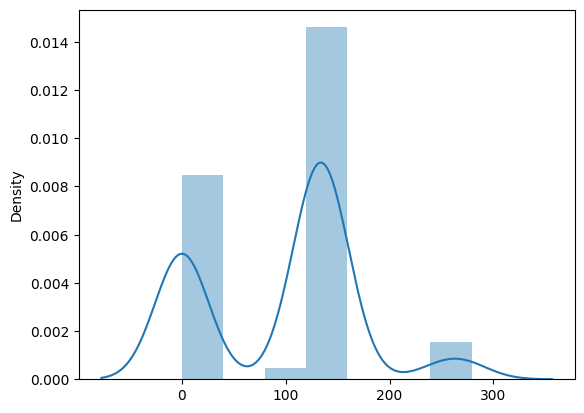

In [9]:
notes_ = df.note.copy() #just use the main bio text in this example
doc_lengths = []

for note_ in notes_:
    # get rough token count distribution
    tokens = nltk.word_tokenize(note_)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
sns.distplot(doc_lengths)

In [10]:
len(doc_lengths[doc_lengths > 768])/len(doc_lengths), np.average(doc_lengths)

(0.0, 96.3755868544601)

Note: Tokenize the text with gpt 2 tokenizer

### GPT2 Tokenizer

In [11]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2',
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')


print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


## PyTorch Datasets & Dataloaders

In [12]:
[len(x) for x in notes_ if len(x) > 768]

[1232, 1297, 1215, 1259, 1187, 1214, 1185, 1242, 1204, 1227, 1239, 1219, 1193]

In [14]:
batch_size = 2

class GPT2Dataset(Dataset):
    
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            
    def __len__(self):
        return len(self.input_ids)

    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [15]:
dataset = GPT2Dataset(notes_, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  191 training samples
   22 validation samples


In [16]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Finetune GPT2 Language Model

In [18]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cpu")
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [19]:
type(configuration)

transformers.models.gpt2.configuration_gpt2.GPT2Config

In [20]:
type(model)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [21]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

In [22]:
# Note: AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [23]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        
        outputs = model( b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 2.04
  Training epoch took: 0:10:45

Running Validation...
  Validation Loss: 0.75
  Validation took: 0:01:09

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.66
  Training epoch took: 0:16:34

Running Validation...
  Validation Loss: 0.73
  Validation took: 0:00:11

======== Epoch 3 / 5 ========
Training...


In [30]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.971706,0.747491,0:06:53,0:00:10
2,0.660566,0.727938,0:06:49,0:00:09
3,0.602841,0.728830,0:06:22,0:00:09
4,0.557080,0.732321,0:06:23,0:00:09
5,0.524830,0.742941,0:06:34,0:00:10


### Metric Plot

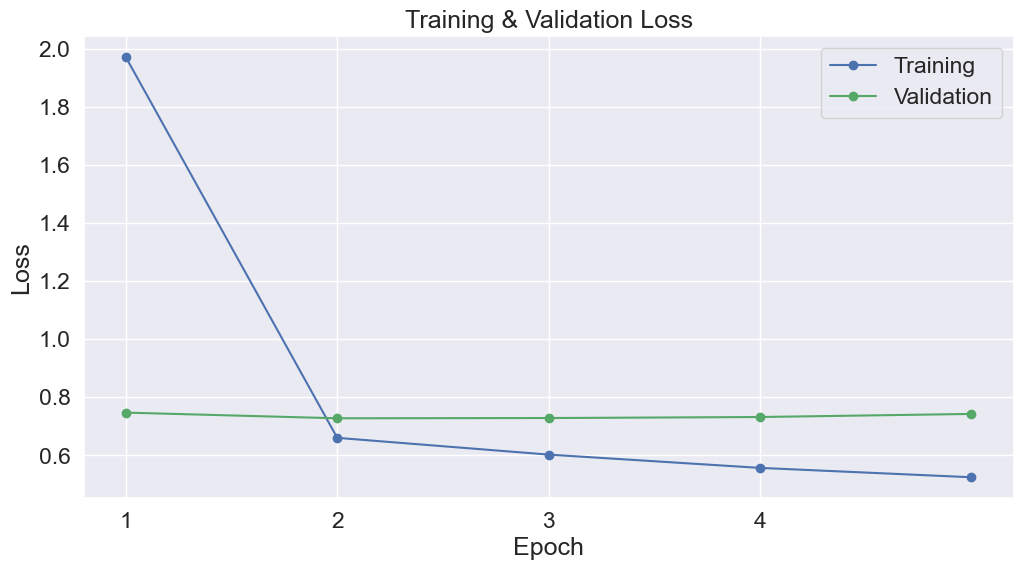

In [31]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Display Model Info

In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

## Saving the Fine-Tuned Model

In [33]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [62]:
output_dir = './model_save/'

In [64]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [63]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [67]:
help(pipeline)

Help on TextGenerationPipeline in module transformers.pipelines.text_generation object:

class TextGenerationPipeline(transformers.pipelines.base.Pipeline)
 |  TextGenerationPipeline(*args, **kwargs)
 |  
 |  Language generation pipeline using any `ModelWithLMHead`. This pipeline predicts the words that will follow a
 |  specified text prompt.
 |  
 |  Example:
 |  
 |  ```python
 |  >>> from transformers import pipeline
 |  
 |  >>> generator = pipeline(model="gpt2")
 |  >>> generator("I can't believe you did such a ", do_sample=False)
 |  [{'generated_text': "I can't believe you did such a icky thing to me. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I'm so sorry. I"}]
 |  
 |  >>> # These parameters will return suggestions, and only the newly created text making it easier for prompting suggestions.
 |  >>> outputs = generator("My tart needs some", num_return_sequences=4, return_full_text=False)
 |  ```
 |  
 |  Learn more about the basics of u

In [69]:
generator = pipeline('text-generation', model, tokenizer=tokenizer, config={'max_length':100})

TypeError: __call__() takes 2 positional arguments but 3 were given

## Loading the New Model

In [50]:
model.eval()

prompt = "the client"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[1169, 5456]])
0: the client heart,
The heart that the love of the world should care
For, and the heart of hearts that hate it shall care
For, and it is the heart that the world should love,
And to the world it should hate is well.
The heart that the world would hate is straight,
Therefore the heart that I love the world to hate be,
To the heart that I love not, it is not true  
And yet for that it be true to hate it be true.


1: the client thing that is,
A thing that hath an end,
And that is the good; that is the bad:
The very thing that commits the crime
For that which is in my power,
Cannot be done, and then I am done.
That which commits the crime commits the robbery:
The one thing is, and that which commits the crime,
Pursues another, in my plea,
Healing the wound, and thereby giving life.


2: the client defendant's worth,
The other's worth what is the sum of the two
The defendant's worth, the other being less:
But if thou then do not give the worth of the first,
A little

In [54]:
from transformers import OpenAIGPTConfig, GPT2LMHeadModel

In [55]:
model_retrained = GPT2LMHeadModel.from_pretrained('model_save')

In [56]:
from transformers import TextGenerationPipeline, OpenAIGPTTokenizer

generator = TextGenerationPipeline(model_retrained, tokenizer=OpenAIGPTTokenizer)

In [57]:
type(model)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [58]:
generator("Client reflects a more balanced", max_length=5, num_return_sequences=5)

TypeError: __init__() missing 1 required positional argument: 'merges_file'

In [40]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model=model_retrained)
set_seed(42)

Exception: Impossible to guess which tokenizer to use. Please provide a PreTrainedTokenizer class or a path/identifier to a pretrained tokenizer.

In [ ]:
class MyPipeline(TextClassificationPipeline):
    
    def postprocess():
        # Your code goes here
        scores = scores * 100
        # And here


my_pipeline = MyPipeline(model=model, tokenizer=tokenizer, ...)
